In [ ]:
import os
import numpy as np
import random
from PIL import Image
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Set random seed
random.seed(42)
torch.manual_seed(42)

# Confugiration
dataset_dir = r"D:\coding\SKRIPSI\CLASSIFICATION MODEL\dataset"
num_classes = 3
num_epochs = 20
batch_size = 1
k_folds = 5

# Patient by categiry
normal_ids = [1003, 1005, 1032, 1051, 1062, 1063, 1066, 1067, 1072, 1078,
              1080, 1083, 1101, 1116, 1117, 1119, 1127, 1128, 1143, 1144]
sianotik_ids = [1008, 1010, 1012, 1015, 1028, 1037, 1046, 1050, 1064, 1074,
                1085, 1092, 1099, 1105, 1111, 1113, 1120, 1125, 1129, 1141,
                1145, 1146, 1147, 1150, 1158, 1178]
non_sianotik_ids = [1001, 1002, 1007, 1011, 1014, 1018, 1019, 1020, 1025, 1029,
                    1033, 1035, 1036, 1041, 1047, 1061, 1070, 1079, 1103, 1109,
                    1132, 1133, 1135, 1139, 1140, 1148]

all_patient_ids = normal_ids + sianotik_ids + non_sianotik_ids
labels = [0]*len(normal_ids) + [1]*len(sianotik_ids) + [2]*len(non_sianotik_ids)

label_map = {pid: label for pid, label in zip(all_patient_ids, labels)}

In [3]:
class CT3DDataset(Dataset):
    def __init__(self, dataset_dir, patient_ids, label_map, transform=None):
        self.dataset_dir = dataset_dir
        self.patient_ids = patient_ids
        self.label_map = label_map
        self.transform = transform

    def __len__(self):
        return len(self.patient_ids)

    def __getitem__(self, idx):
        pid = self.patient_ids[idx]
        folder = os.path.join(self.dataset_dir, f"ct_{pid}")

        frames = []
        for i in range(1, 276):
            img_path = os.path.join(folder, f"{pid}_{i:03d}.png")
            img = Image.open(img_path).convert("L")
            img = transforms.ToTensor()(img)
            frames.append(img.squeeze(0))

        volume = torch.stack(frames, dim=0)  # (275, 256, 256)
        volume = volume.unsqueeze(0)         # (1, 275, 256, 256)
        label = self.label_map[pid]
        return volume, torch.tensor(label).long()

In [4]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes=3, hidden_size=128):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.dropout = nn.Dropout(0.5)
        self.feature_dim = 64 * 32 * 32
        self.lstm = nn.LSTM(self.feature_dim, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        B, C, T, H, W = x.shape
        x = x.squeeze(1)  # (B, T, H, W)
        features = []
        for t in range(T):
            out = self.cnn(x[:, t].unsqueeze(1))
            out = out.view(B, -1)
            features.append(out)
        features = torch.stack(features, dim=1)  # (B, T, feature_dim)
        lstm_out, _ = self.lstm(self.dropout(features))
        last_hidden = lstm_out[:, -1, :]
        return self.fc(last_hidden)


===== Fold 1/5 =====
[Epoch 1/20] Loss: 0.2874, Train Acc: 0.2632, Val Acc: 0.3333
[Epoch 2/20] Loss: 0.2877, Train Acc: 0.2982, Val Acc: 0.3333
[Epoch 3/20] Loss: 0.2858, Train Acc: 0.3509, Val Acc: 0.4667
[Epoch 4/20] Loss: 0.2919, Train Acc: 0.3509, Val Acc: 0.3333
[Epoch 5/20] Loss: 0.3033, Train Acc: 0.4561, Val Acc: 0.3333
[Epoch 6/20] Loss: 0.2884, Train Acc: 0.5088, Val Acc: 0.4000
[Epoch 7/20] Loss: 0.2854, Train Acc: 0.5965, Val Acc: 0.4667
[Epoch 8/20] Loss: 0.3092, Train Acc: 0.7193, Val Acc: 0.5333
[Epoch 9/20] Loss: 0.3186, Train Acc: 0.7895, Val Acc: 0.4000
[Epoch 10/20] Loss: 0.3718, Train Acc: 0.8947, Val Acc: 0.2667
[Epoch 11/20] Loss: 0.3871, Train Acc: 0.8947, Val Acc: 0.2667
[Epoch 12/20] Loss: 0.4572, Train Acc: 0.9649, Val Acc: 0.2667
[Epoch 13/20] Loss: 0.4934, Train Acc: 0.9649, Val Acc: 0.4000
[Epoch 14/20] Loss: 0.4703, Train Acc: 0.9825, Val Acc: 0.3333
[Epoch 15/20] Loss: 0.4771, Train Acc: 1.0000, Val Acc: 0.3333
[Epoch 16/20] Loss: 0.5384, Train Acc: 1.0

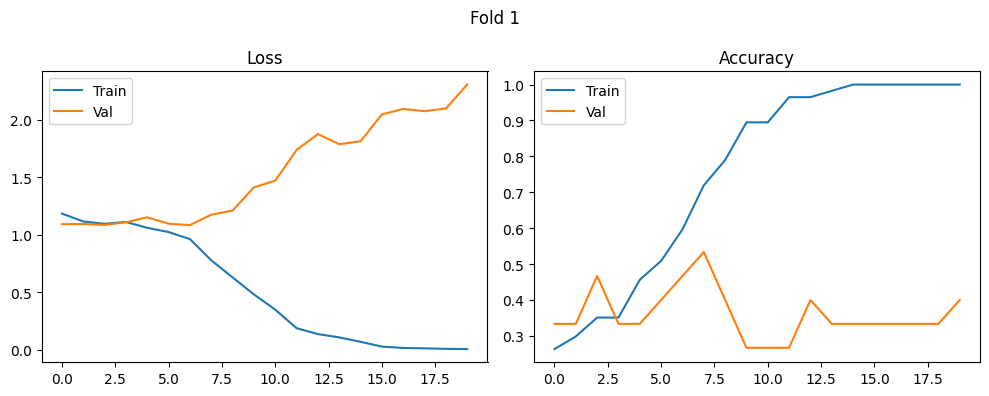

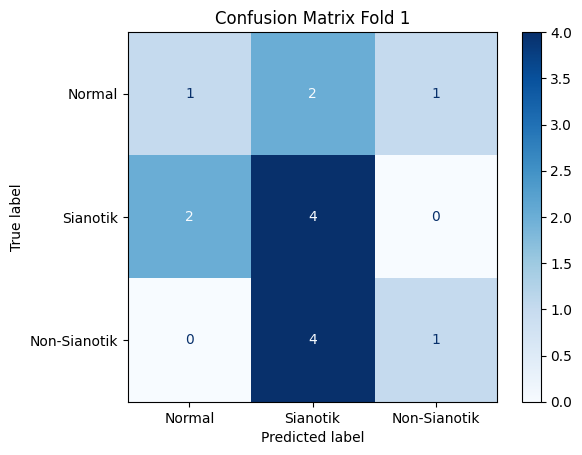


===== Fold 2/5 =====
[Epoch 1/20] Loss: 0.2883, Train Acc: 0.3158, Val Acc: 0.3333
[Epoch 2/20] Loss: 0.2885, Train Acc: 0.3333, Val Acc: 0.3333
[Epoch 3/20] Loss: 0.2904, Train Acc: 0.3684, Val Acc: 0.3333
[Epoch 4/20] Loss: 0.2859, Train Acc: 0.4561, Val Acc: 0.4667
[Epoch 5/20] Loss: 0.2846, Train Acc: 0.4737, Val Acc: 0.4000
[Epoch 6/20] Loss: 0.3118, Train Acc: 0.4737, Val Acc: 0.4000
[Epoch 7/20] Loss: 0.3163, Train Acc: 0.6140, Val Acc: 0.3333
[Epoch 8/20] Loss: 0.3507, Train Acc: 0.6667, Val Acc: 0.2667
[Epoch 9/20] Loss: 0.3762, Train Acc: 0.8421, Val Acc: 0.4000
[Epoch 10/20] Loss: 0.3642, Train Acc: 0.8947, Val Acc: 0.4000
[Epoch 11/20] Loss: 0.4096, Train Acc: 0.9825, Val Acc: 0.3333
[Epoch 12/20] Loss: 0.4693, Train Acc: 1.0000, Val Acc: 0.2667
[Epoch 13/20] Loss: 0.5150, Train Acc: 1.0000, Val Acc: 0.3333
[Epoch 14/20] Loss: 0.5831, Train Acc: 1.0000, Val Acc: 0.3333
[Epoch 15/20] Loss: 0.5823, Train Acc: 1.0000, Val Acc: 0.3333
[Epoch 16/20] Loss: 0.6770, Train Acc: 1.0

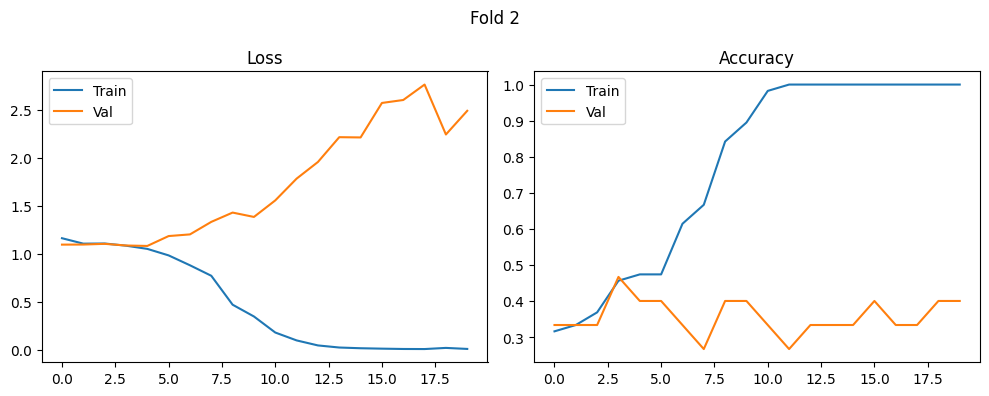

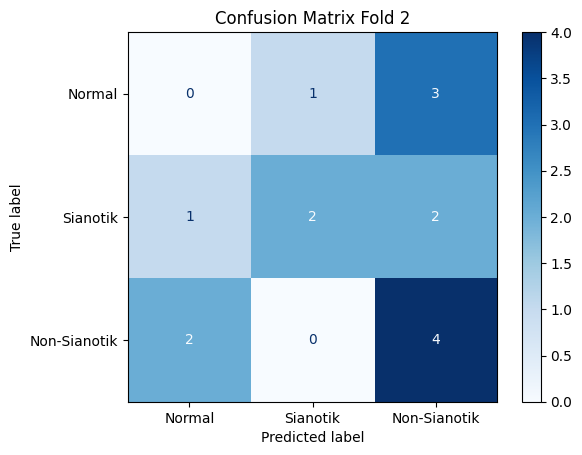


===== Fold 3/5 =====
[Epoch 1/20] Loss: 0.2644, Train Acc: 0.3448, Val Acc: 0.3571
[Epoch 2/20] Loss: 0.2687, Train Acc: 0.3966, Val Acc: 0.3571
[Epoch 3/20] Loss: 0.2674, Train Acc: 0.3966, Val Acc: 0.3571
[Epoch 4/20] Loss: 0.2698, Train Acc: 0.3621, Val Acc: 0.3571
[Epoch 5/20] Loss: 0.2695, Train Acc: 0.4138, Val Acc: 0.2143
[Epoch 6/20] Loss: 0.2749, Train Acc: 0.4138, Val Acc: 0.3571
[Epoch 7/20] Loss: 0.2970, Train Acc: 0.5517, Val Acc: 0.5000
[Epoch 8/20] Loss: 0.2668, Train Acc: 0.6552, Val Acc: 0.2143
[Epoch 9/20] Loss: 0.3009, Train Acc: 0.7759, Val Acc: 0.2857
[Epoch 10/20] Loss: 0.2715, Train Acc: 0.8966, Val Acc: 0.4286
[Epoch 11/20] Loss: 0.2866, Train Acc: 0.9483, Val Acc: 0.3571
[Epoch 12/20] Loss: 0.3170, Train Acc: 0.9828, Val Acc: 0.3571
[Epoch 13/20] Loss: 0.3041, Train Acc: 1.0000, Val Acc: 0.3571
[Epoch 14/20] Loss: 0.3562, Train Acc: 1.0000, Val Acc: 0.2857
[Epoch 15/20] Loss: 0.3430, Train Acc: 1.0000, Val Acc: 0.3571
[Epoch 16/20] Loss: 0.3382, Train Acc: 1.0

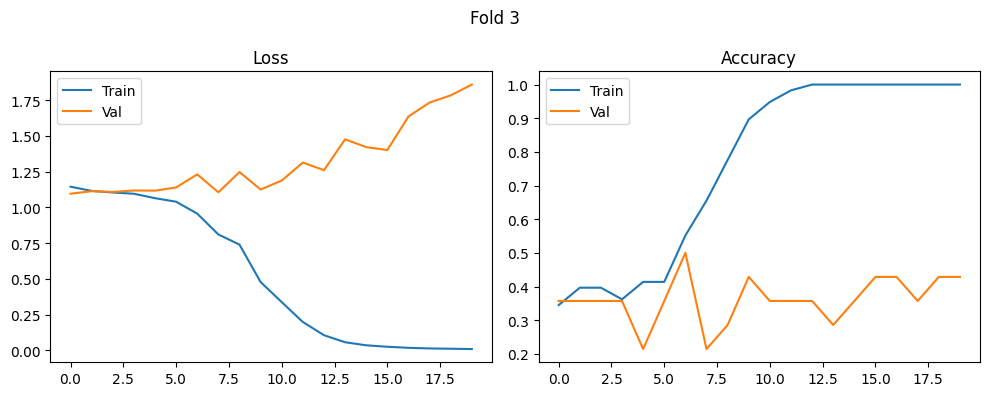

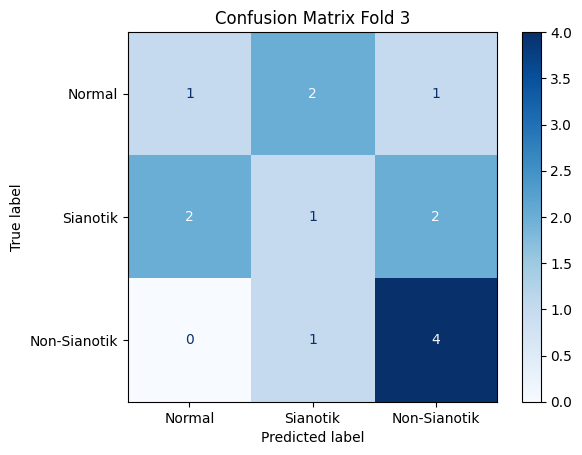


===== Fold 4/5 =====
[Epoch 1/20] Loss: 0.2687, Train Acc: 0.3276, Val Acc: 0.3571
[Epoch 2/20] Loss: 0.2642, Train Acc: 0.2931, Val Acc: 0.3571
[Epoch 3/20] Loss: 0.2654, Train Acc: 0.5172, Val Acc: 0.2857
[Epoch 4/20] Loss: 0.2708, Train Acc: 0.5000, Val Acc: 0.4286
[Epoch 5/20] Loss: 0.2780, Train Acc: 0.5862, Val Acc: 0.4286
[Epoch 6/20] Loss: 0.3356, Train Acc: 0.6897, Val Acc: 0.2857
[Epoch 7/20] Loss: 0.3186, Train Acc: 0.7931, Val Acc: 0.3571
[Epoch 8/20] Loss: 0.3751, Train Acc: 0.7931, Val Acc: 0.2143
[Epoch 9/20] Loss: 0.3619, Train Acc: 0.9310, Val Acc: 0.4286
[Epoch 10/20] Loss: 0.3756, Train Acc: 0.9483, Val Acc: 0.4286
[Epoch 11/20] Loss: 0.3713, Train Acc: 1.0000, Val Acc: 0.4286
[Epoch 12/20] Loss: 0.3980, Train Acc: 1.0000, Val Acc: 0.4286
[Epoch 13/20] Loss: 0.3990, Train Acc: 1.0000, Val Acc: 0.3571
[Epoch 14/20] Loss: 0.4339, Train Acc: 1.0000, Val Acc: 0.4286
[Epoch 15/20] Loss: 0.4825, Train Acc: 1.0000, Val Acc: 0.2857
[Epoch 16/20] Loss: 0.4668, Train Acc: 1.0

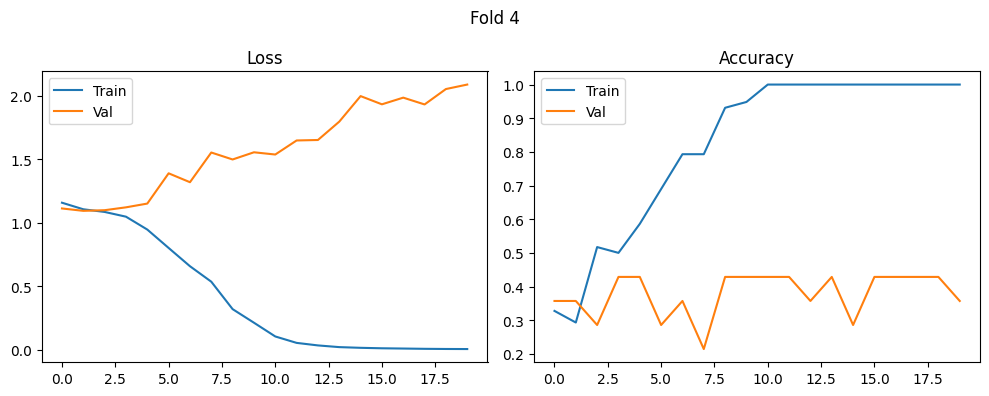

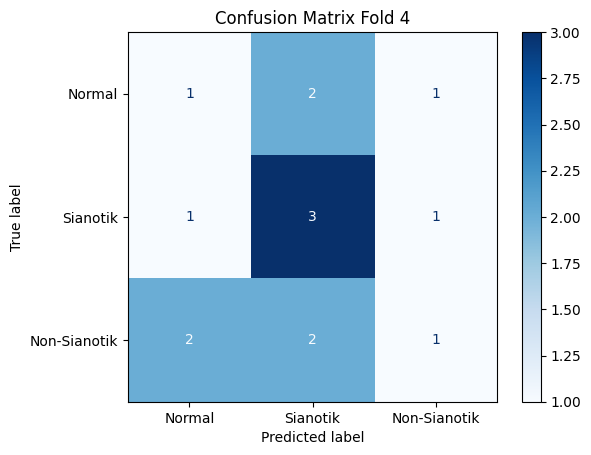


===== Fold 5/5 =====
[Epoch 1/20] Loss: 0.2641, Train Acc: 0.3966, Val Acc: 0.3571
[Epoch 2/20] Loss: 0.2649, Train Acc: 0.3276, Val Acc: 0.3571
[Epoch 3/20] Loss: 0.2634, Train Acc: 0.3276, Val Acc: 0.3571
[Epoch 4/20] Loss: 0.2636, Train Acc: 0.3621, Val Acc: 0.3571
[Epoch 5/20] Loss: 0.2629, Train Acc: 0.3793, Val Acc: 0.4286
[Epoch 6/20] Loss: 0.2620, Train Acc: 0.3793, Val Acc: 0.4286
[Epoch 7/20] Loss: 0.2608, Train Acc: 0.3793, Val Acc: 0.3571
[Epoch 8/20] Loss: 0.2582, Train Acc: 0.3793, Val Acc: 0.3571
[Epoch 9/20] Loss: 0.2596, Train Acc: 0.4828, Val Acc: 0.3571
[Epoch 10/20] Loss: 0.2556, Train Acc: 0.4138, Val Acc: 0.3571
[Epoch 11/20] Loss: 0.2486, Train Acc: 0.5862, Val Acc: 0.5000
[Epoch 12/20] Loss: 0.2607, Train Acc: 0.5172, Val Acc: 0.5000
[Epoch 13/20] Loss: 0.2265, Train Acc: 0.7069, Val Acc: 0.6429
[Epoch 14/20] Loss: 0.2109, Train Acc: 0.8276, Val Acc: 0.5714
[Epoch 15/20] Loss: 0.2480, Train Acc: 0.9483, Val Acc: 0.6429
[Epoch 16/20] Loss: 0.2950, Train Acc: 1.0

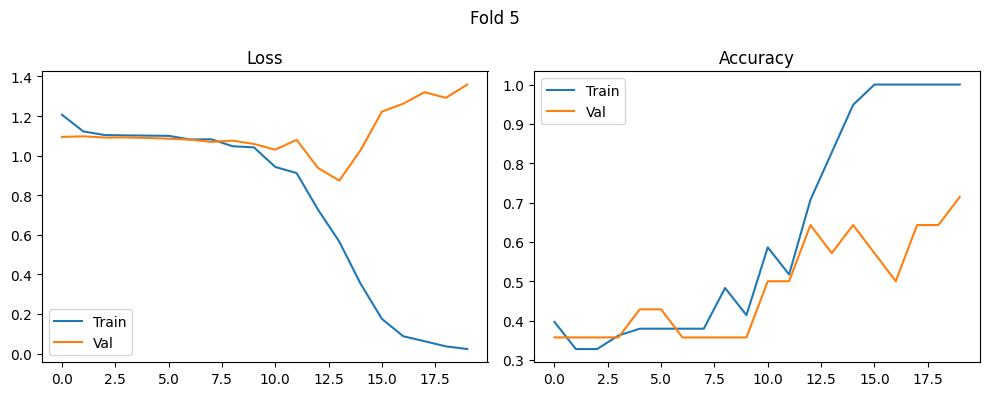

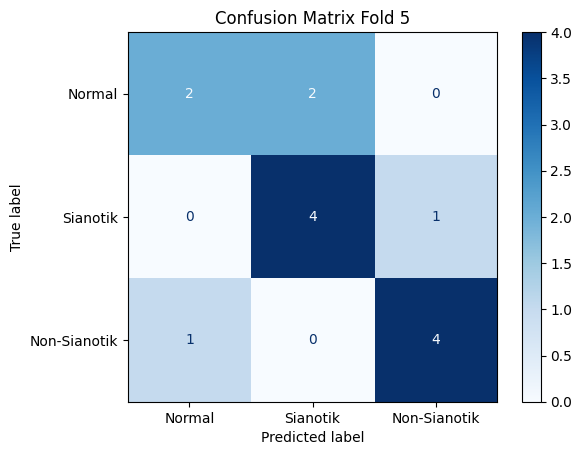

In [ ]:
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_idx, val_idx) in enumerate(skf.split(all_patient_ids, labels)):
    print(f"\n===== Fold {fold+1}/{k_folds} =====")
    train_ids = [all_patient_ids[i] for i in train_idx]
    val_ids = [all_patient_ids[i] for i in val_idx]

    train_dataset = CT3DDataset(dataset_dir, train_ids, label_map)
    val_dataset = CT3DDataset(dataset_dir, val_ids, label_map)

    train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=1)

    model = CNN_LSTM(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        train_losses.append(total_loss/len(train_loader))
        train_accs.append(correct/total)

        model.eval()
        total_loss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss = criterion(out, y)
                total_loss += loss.item()
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        val_losses.append(total_loss/len(val_loader))
        val_accs.append(correct/total)

        print(f"[Epoch {epoch+1}/{num_epochs}] Loss: {total_loss/len(train_loader):.4f}, Train Acc: {train_accs[-1]:.4f}, Val Acc: {val_accs[-1]:.4f}")

    torch.save(model.state_dict(), f"cnn_lstm_fold{fold+1}.pth")

     # Plot curve
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label="Train")
    plt.plot(val_losses, label="Val")
    plt.title("Loss")
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(train_accs, label="Train")
    plt.plot(val_accs, label="Val")
    plt.title("Accuracy")
    plt.legend()
    plt.suptitle(f"Fold {fold+1}")
    plt.tight_layout()
    plt.savefig(f"fold{fold+1}_curve.png")
    plt.show()

    # Confusion Matrix
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for x, y in val_loader:
            x = x.to(device)
            out = model(x)
            y_true.append(y.item())
            y_pred.append(out.argmax(1).item())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(cm, display_labels=["Normal", "Sianotik", "Non-Sianotik"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix Fold {fold+1}")
    plt.savefig(f"fold{fold+1}_confusion.png")
    plt.show()